In [100]:
# 파이썬 3.8 만들기
# conda create -n conda38 python=3.8 anaconda
# conda install python = 3.8

패키지 설치

In [11]:
pip install tensorflow

  Using cached tensorflow-2.8.0-cp38-cp38-win_amd64.whl (438.0 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached typing_extensions-4.1.1-py3-none-any.whl (26 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached wrapt-1.14.0-cp38-cp38-win_amd64.whl (36 kB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached libclang-13.0.0-py2.py3-none-win_amd64.whl (13.9 MB)
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached gast-0.5.3-py3-none-any.whl (19 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using 

In [12]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from sklearn.model_selection import train_test_split

파일불러오기

In [13]:
import os
print(os.getcwd())

c:\Users\dkq50\OneDrive\바탕 화면\자연어처리\프로젝트\project-nlp-main


In [14]:
ratings = pd.read_csv('./data/ratings.txt',header = 0, delimiter = '\t', quoting=3)
ratings.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [15]:
print('전체 리뷰 개수 :',len(ratings)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


null값을 확인 및 중복값을 제거

In [16]:
ratings['id'].nunique(), ratings['document'].nunique(), ratings['label'].nunique()

(200000, 194543, 2)

In [17]:
ratings.isnull().sum()

id          0
document    8
label       0
dtype: int64

In [18]:
ratings = ratings.dropna(axis=0)
ratings.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [19]:
ratings.drop_duplicates(subset = ["document"], inplace = True)

In [20]:
print('중복값 제거 후 :',len(ratings)) # 전체 리뷰 개수 출력

중복값 제거 후 : 194543


In [21]:
print(ratings.isnull().values.any())

False


다음 영화 평 데이터

In [22]:
daum = pd.read_csv('./data/comment_suc.csv', encoding = 'cp949')
daum.head()

,id,document,label
0,739929959,누가 도깨비에요?,0
1,597672743,진심 망작..,0
2,597585065,셍각보다 재미났어요 \n코믹케릭도 괜찮고 설정도 재미났어요 ㅎ,1
3,597562997,3탄 가즈아~~~,1
4,597560513,일진시리즈중 최고네요,1


In [23]:
print('전체 리뷰 개수 :',len(daum)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 2992


In [24]:
daum['id'].nunique(), daum['document'].nunique(), daum['label'].nunique()

(2992, 2869, 2)

In [25]:
daum.drop_duplicates(subset=['document'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('중복제거 후 :',len(daum))

중복제거 후 : 2869


In [26]:
print(daum.isnull().values.any())

False


In [27]:
Data = pd.concat([ratings, daum])
print('전체 데이터 수 :', len(Data))

전체 데이터 수 : 197412


In [28]:
train, test = train_test_split(Data, test_size=0.1, random_state=220320)
print('훈련용 리뷰의 개수 :', len(train))
print('테스트용 리뷰의 개수 :', len(test))

훈련용 리뷰의 개수 : 177670
테스트용 리뷰의 개수 : 19742


In [33]:
# 데이터셋 내보내기
train.to_csv('./data/train_data.csv', encoding='cp949') 
test.to_csv('./data/test_data.csv', encoding='cp949') 

학습이 편향되지 않기 위해서는 label이 균일하게 분포되어있는 지 확인

   label  count
0      0  87953
1      1  88745


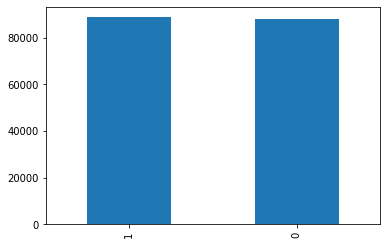

In [34]:
train['label'].value_counts().plot(kind = 'bar')
print(train.groupby('label').size().reset_index(name = 'count'))

한글을 제외한 나머지는 빈칸으로 바꿔주고 빈칸을 null로 바꾼다음 null값을 제거

In [35]:
train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

train['document'] = train['document'].str.replace('^ +', "")
test['document'] = test['document'].str.replace('^ +', "")
train['document'].replace('', np.nan, inplace = True)
test['document'].replace('', np.nan, inplace = True)

C:\Users\dkq50\AppData\Local\Temp\ipykernel_18768\2353780523.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\Users\dkq50\AppData\Local\Temp\ipykernel_18768\2353780523.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\Users\dkq50\AppData\Local\Temp\ipykernel_18768\2353780523.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train['document'] = train['document'].str.replace('^ +', "")
C:\Users\dkq50\AppData\Local\Temp\ipykernel_18768\2353780523.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test['document'] = test['document'].str.replace('^ +', "")


In [36]:
train = train.dropna(axis=0)
test = test.dropna(axis=0)
print(train.isnull().sum(), '\n', test.isnull().sum())

id          0
document    0
label       0
dtype: int64 
 id          0
document    0
label       0
dtype: int64


In [116]:
a = pd.read_csv('./data/stopwords2.csv', encoding = 'cp949')

In [117]:
stopwords = list(a['stopwords'])

문장을 단어단위로 쪼개어 리스트에 넣어주는 작업

In [57]:
t_train = [] 
t_test = []
for sentence in train['document']:
    temp_X = okt.morphs(sentence, stem = True) 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    t_train.append(temp_X)
    
for sentence in test['document']:
    temp_X = okt.morphs(sentence, stem = True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    t_test.append(temp_X)

쪼개진 단어들에 숫자를 붙여주었다. 딥러닝을 위한 단계!

In [58]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(t_train)
tokenizer.fit_on_texts(t_test)

단어사전

In [59]:
import pickle
 
## Save pickle
with open("./data/movie.pickle","wb") as fw:
    pickle.dump(tokenizer, fw)

In [60]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 : 50201
등장 빈도가 2번 이하인 희귀 단어의 수: 27715
단어 집합에서 희귀 단어의 비율: 55.20806358439076
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.5606006271091373


등장 빈도가 threshold 값인 3회 미만. 즉, 2회 이하인 단어들은 단어 집합에서 무려 절반 이상을 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 1.56%밖에 되지 않습니다. 아무래도 등장 빈도가 2회 이하인 단어들은 자연어 처리에서 별로 중요하지 않을 듯 합니다. 그래서 이 단어들은 정수 인코딩 과정에서 배제시키겠습니다.

등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한하겠습니다.

In [61]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 22487


In [62]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(t_train)

In [123]:
X_train1 = tokenizer.texts_to_sequences(t_train)
X_test1 = tokenizer.texts_to_sequences(t_test)

In [64]:
print(X_train1[:3])

[[61, 162, 34, 162, 156, 146], [217, 105, 702], [364, 1356, 92, 361, 5111, 2, 1641, 6839, 2299]]


각 샘플 내의 단어들은 각 단어에 대한 정수로 변환된 것을 확인할 수 있습니다. 단어의 개수는 22,487개로 제한되었으므로 0번 단어 ~ 22,487번 단어까지만 사용 중입니다. 0번 단어는 패딩을 위한 토큰임을 상기합시다. train_data에서 y_train과 y_test를 별도로 저장해줍니다.

In [128]:
y_train = np.array(train['label'])
y_test = np.array(test['label'])

문장의 최대 길이 : 127
문장의 평균 길이 : 10.916201654800847


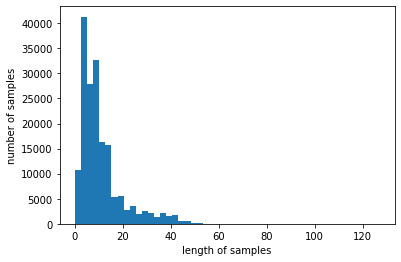

In [66]:
print('문장의 최대 길이 :',max(len(l) for l in X_train1)) # 단어의 수
print('문장의 평균 길이 :',sum(map(len, X_train1))/len(X_train1))
plt.hist([len(s) for s in X_train1], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [67]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))
 
# 이 값이 얼마나 많은 리뷰 길이를 커버하는지 확인.
max_len = 45
below_threshold_len(max_len, X_train1)

전체 샘플 중 길이가 45 이하인 샘플의 비율: 99.52914011477209


길이를 길게 잡을 경우 학습에 시간이 오래걸리기 때문에 가장 데이터손실이 적으면서도 학습시간을 줄일 수 있도록 전체의 99.43%를 포함하도록 문장길이를 45로 설정하였다.

패딩

In [68]:
X_train2 = pad_sequences(X_train1, maxlen = max_len)
X_test2 = pad_sequences(X_test1, maxlen = max_len)

딥러닝 모듈

In [69]:
from keras import models
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [70]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.5)) # 구글링의 결과 0.2 ~ 0.5이 적합하다고 나옴
model.add(GRU(128))
model.add(Dropout(0.5)) # 0.5 이하로는 과대적합의 경향이 많이 나타남
model.add(Dense(1, activation='sigmoid'))

model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='mse', metrics=['acc'])
history = model.fit(X_train2, y_train, epochs=15, callbacks=[es, mc], batch_size=6000, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         2248700   
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         117248    
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,465,149
Trainable params: 2,465,149
No

- loss : 훈련 손실값
- acc : 훈련 정확도
- val_loss : 검증 손실값
- val_acc : 검증 정확도

In [71]:
loaded_model = load_model('bilstm.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test2, y_test)[1]))

615/615 [==============================] - 10s 15ms/step - loss: 0.1164 - acc: 0.8408

 테스트 정확도: 0.8408


In [ ]:
from tensorflow.keras.models import load_model
import random
from konlpy.tag import Okt
import os
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

okt = Okt()
loaded_model = load_model('bilstm.h5')
max_len = 42

global corpus
global avg_emo
global score

corpus = []
avg_emo = 0


heal = ['여수 밤바다', '파주 평화누리공원', '순천 갈대밭', '제주도 영실코스', 
         '진주 진양호', '장흥유원지', '대구 앞산정만대', '춘천 해피초원농장' ,' 속초 해수욕장', 
         '경주 불국사', '포항 호미곶', '남해 두모마을', '대관령 하늘목장', '군산 철길마을', 
         '국립 광릉수목원', '금선사 템플스테이', '보성 제암산자연휴양림','군산 선유도']
 
extreme= ['통영 어드벤처 타워', '제주도  스쿠버다이빙', '단양 패러글라이딩', 
          '강원 내린천 래프팅', '충주 스카이다이빙', '하남 스포츠몬스터', '서울 한강 워터 제트팩', 
          '일산 인공 서핑', '영월 동강래프팅', '여수 스카이플라이', '문경 패러글라이딩', 
          '경남 하동 하동알프스레포츠', '인천 스카이 짚라인', '강화 루지']
 
movie=['루카','콰이어트 플레이스','크루엘라','컨저링 3:악마가 시켰다','여고괴담 여섯번째 이야기','분노의 질주: 더 얼티메이트','캐시트럭',
'클라이밍',
'그 여름, 가장 차가웠던',
'폭력의 그림자',
'청춘 선거',
'그레타 툰베리',
'낫아웃',
'마세티 킬즈',
'프로페서 앤 매드맨',
'화이트 온 화이트',
'아야와 마녀',
'까치발',
'플래시백',
'애플',
'혼자 사는 사람들',
'강호아녀',
'파이프라인',
'분노의 질주']
 
#음악 (네이버 바이브 참고 1위~20위)
 
k_balad=['Timeless-SG워너비',
'추적이는 여름 비가 되어-장범준',
'밤하늘의 별을 (2020)-경서',
'어떻게 이별까지 사랑하겠어, 널 사랑하는 거지-AKMU (악동뮤지션)',
'내 입술 따뜻한 커피처럼-청하 Colde(콜드)',
'서울의 잠 못 이루는 밤 (Feat. 이수현)-10CM',
'잠이 오질 않네요-장범준',
'I Love U-성시경',
'내사람 (Partner For Life)-SG워너비',
'취기를 빌려-산들',
'안녕 (Hello)-조이',
'밤편지-아이유(IU)',
'Anti-Romantic-투모로우바이투게더',
'너의 모든 순간-성시경',
'좋을텐데 (If Only) (Feat. 폴킴)-조이',
'봄 안녕 봄-아이유(IU)',
'Love poem -아이유(IU)',
'아이와 나의 바다-아이유(IU)',
'벌써 일년-반하나& MJ(써니사이드)',
'이렇게 좋아해 본 적이 없어요 -CHEEZE (치즈)'
]
 
k_dance=[
'Butter-방탄소년단',
'Next Level-aespa',
'Dun Dun Dance-오마이걸(OH MY GIRL)',
'치맛바람 (Chi Mat Ba Ram)-브레이브걸스(Brave Girls)',
'Alcohol-Free-TWICE(트와이스)',
"롤린 (Rollin')-브레이브걸스(Brave Girls)",
'라일락-아이유(IU)',
'ASAP-STAYC(스테이씨)',
'Dynamite-방탄소년단',
'상상더하기-MSG워너비',
'Celebrity-아이유(IU)',
'상상더하기-라붐(LABOUM)',
'Ready to love-세븐틴',
'Dolphin-오마이걸(OH MY GIRL)',
'Lovesick Girls-BLACKPINK',
'Pool Party (Feat. 이찬 of DKB)-브레이브걸스(Brave Girls)',
"Heaven's Cloud-세븐틴",
'체념-정상동기(김정수, 정기석, 이동휘, 이상이)',
'어푸 (Ah puh)-아이유(IU)',
]
 
k_hip=[
'마.피.아. In the morning-ITZY(있지)',
'봄날-방탄소년단',
'Life Goes On-방탄소년단',
'맛 (Hot Sauce)-NCT DREAM',
'밸런스 게임-투모로우바이투게더',
'GAM3 BO1-세븐틴',
'비도 오고 그래서 (Feat. 신용재)-헤이즈 (Heize)',
'METEOR-창모(CHANGMO)',
'DNA-방탄소년단',
'IDOL-방탄소년단',
'FAKE LOVE-방탄소년단',
'피 땀 눈물-방탄소년단',
'사이렌-호미들',
'멜로디-ASH ISLAND',
'I NEED U-방탄소년단',
'아무노래-지코 (ZICO)',
'어떻게 지내 (Prod. By VAN.C)-오반(OVAN)',
'Rainy day (Feat. ASH ISLAND, Skinny Brown)-PATEKO(파테코)',
'뚜두뚜두 (DDU-DU DDU-DU)-BLACKPINK']
 
 
trt=[
'이제 나만 믿어요-임영웅',
'별빛 같은 나의 사랑아-임영웅',
'다시 사랑한다면 (김필 Ver.)-임영웅',
'HERO-임영웅',
'미워요-임영웅',
'잊어야 한다는 마음으로-임영웅',
'계단말고 엘리베이터-임영웅',
'소나기-임영웅',
'바보같지만-임영웅',
'따라따라-임영웅',
'당신-임영웅',
'내 마음 별과 같이-임영웅',
'고맙소-김호중',
'만개 (Prod. 신지후)-김호중',
'나보다 더 사랑해요-김호중',
'애인이 되어줄게요 (Prod. 알고보니, 혼수상태)-김호중',
'퇴근길-김호중',
'할무니-김호중',
'우산이 없어요-김호중',
'천년의 사랑-김호중'
]
 
 
f_dance=[
'You-Regard, Troye Sivan, Tate McRae',
'Closer (Feat. Halsey)-The Chainsmokers',
'Faded-Alan Walker',
'One Kiss-Calvin Harris, Dua Lipa',
'Heartbreak Anthem-Galantis, David Guetta, Little Mix',
'Something Just Like This-The Chainsmokers, Coldplay',
'This Is What You Came For (Feat. Rihanna)-Calvin Harris',
'The Middle-Zedd, Grey, Maren Morris',
'Symphony (Feat. Zara Larsson)-Clean Bandit',
'Wake Me Up-Avicii',
'Waste It On Me (Feat. BTS(방탄소년단))-Steve Aoki',
'How To Love (Feat. Sofia Reyes)-Cash Cash',
'Bad Boy (with Wiz Khalifa, bbno$, MAX)-Yung Bae, Wiz Khalifa, bbno$, MAX',
'Titans (Feat. Sia & Labrinth) (Imanbek Remix)-Major Lazer',
'Feels (Feat. Pharrell Williams, Katy Perry, Big Sean)-Calvin Harris',
'Rise (Feat. Jack & Jack)-Jonas Blue',
'Mama (Feat. William Singe)-Jonas Blue',
'Just Got Paid (Feat. French Montana)-Sigala, Ella Eyre, Meghan Trainor',
'Love Line-Shift K3y, Tinashe',
'Lonely Together (Feat. Rita Ora)-Avicii'
]
 
newage=[
'River Flows In You-이루마',
'Letter From The Earth (지구에서 온 편지)-김광민',
'익숙한 그 집 앞-유희열',
'처음부터 지금까지 (Inst.)-박정원',
'냉정과 열정 사이 OST (冷靜と情熱のあいだ)-Ryo Yoshimata',
'''Tomorrow's Promise-Kevin Kern''',
"Mia & Sebastian's Theme-Justin Hurwitz",
'Recuerods de la Alhambra (알함브라 궁전의 추억)-Claude Ciari',
'''Gabriel's Oboe-Ennio Morricone''',
'Rain-Ryuichi Sakamoto',
'Romance-Yuhki Kuramoto',
'Second Romance-Yuhki Kuramoto',
'Crystal Rainbow-데이드림(Daydream)',
'My Road (Live)-Lee Oskar',
'Last Carnival-Acoustic Cafe',
'Return To The Heart-David Lanz',
'Adagio-Secret Garden',
'Loving You-Kenny G'
]

korean = ["삼계탕", "삼겹살", "곱창", "찜닭", "오리고기", "소고기", 
          "국밥", "닭도리탕", "낙곱새", "라면", "비빔밥", "칼국수", 
          "수제비", "갈비", "제육볶음"]

western = ["스테이크", "파스타", "필라프", "감바스", "리조또", "샐러드", 
           "피자", "빠에야", "플래터", "스튜"]

asian = ["짜장면", "뿌팟퐁커리", "팟타이", "나시고랭", "쌀국수", "미고랭",
         "카레", "마라탕", "마라샹궈", "훠궈", "돈까스", "월남쌈", "라멘", 
         "탄탄멘", "규동", "꿔바로우", "똠양꿍", "물냉면"]

spicy = ["떡볶이", "김치찜", "김치찌개", "감자탕", "짬뽕", "닭발", "부대찌개",
         "순두부찌개", "아구찜", "해물찜", "육개장", "낙지볶음", "쭈꾸미", 
         "돼지갈비찜", "소꼬리찜", "비빔냉면"]

dessert = ["와플", "마카롱", "빙수", "크로크모슈", "케이크", "허니바게트볼",
           "머쉬룸수프볼", "에그데니쉬", "케이크", "치아바타", "호두파운드케이크",
           "쿠키", "허니브레드", "오믈렛", "베이글"]

snack = ["닭강정", "양꼬치", "핫윙", "소떡소떡", "가라아게", "콘치즈", "감자튀김", 
         "치킨너겟", "치킨", "낫쵸", "소시지", "버터구이", "계란찜", "핫도그", 
         "해쉬브라운"]

coffee = ["아메리카노", "콜드브루", "바닐라 라떼", "카페 라떼", "카라멜 마키아또",
          "카페 모카", "바닐라 프라페", "카페모카 프라페", "연유 라떼", "화이트 모카",
          "민트 모카", "헤이즐넛 라떼", "에스프레소", "오곡 프라페", "쿠앤크 프라페"]

beverage = ["초코 라떼", "민트초코 라떼", "밀크티", "흑당 버블티", "레몬차", "자몽차",
            "유자차", "모히토", "요거트 스무디", "블루베리 스무디", "딸기 스무디", "애플망고 스무디",
            "레몬 에이드", "자몽 에이드", "생과일 주스"]

motivation = ["자신을 믿어라. 자신의 능력을 신뢰하라. 겸손하지만 합리적인 자신감 없이는 성공할 수도 행복할 수도 없다. - 노먼 빈센트 필",
"조금 더 많이 인내하자. 조금 더 많이 노력하자. 그러면 절망적 실패로 보였던 것이 빛나는 성공으로 변할 수 있다. - 알버트 휴버드",
"당신이 인생의 주인공이기 때문이다. 그 사실을 잊지말라. 지금까지 당신이 만들어온 의식적 그리고 무의식적 선택으로 인해 지금의 당신이 있는것이다. - 바바라 홀",
"먹는 칼로리보다 에너지 소모가 적으면 살이 찌듯이, 걱정만 하고 행동하지 않으면 걱정이 찐다.",
"이미 끝나버린 일을 후회하기 보다는 하고 싶었던 일을 하지 못한 것을 후회하라 - 탈무드",
"기회가 주어지면 최선을 다하는 것이 아니라 최선을 다하고 있으면 기회가 주어지는 것이다 - 신영준",
"낭비한 시간에 대한 후회는 더 큰 시간 낭비이다 - 메이슨 쿨리",
"성공은 매일 부단하게 반복된 작은 노력의 합산이다.",
"현명한 사람은 앉아서 손해 본 것을 한탄만 하지 않고 즐겁게 그 손해를 회복할 방법을 찾는다. - 셰익스피어",
"고통을 주지 않는것은 쾌락도 주지 않는다 - 몽테뉴",
"시간은 간다",
"살아가는 사람들 중 대부분은 자신에게 올 기회를 기다리나 기회라는 것은 기다리는 사람에게는 쉽게 오지 않는 법이다",
"기회를 얻을 수 있게 기다리는 사람이 되기보다는 기회를 얻을 수 있는 실력을 먼저 쌓아야 한다. 자신이 하는 일에 열중하고 노력하다보면 자연스럽게 기회는 찾아온다.",
"변화를 위해서 가장 중요한 것은 행동하는 첫걸음이다.",
"무엇이든 하루아침에 만들어지는 것은 없다. 로마 또한 하루아침에 만들어지지 않았다. 이 말은 무언가를 만들기 위해서는 그것을 만들기 위해 노력하고 집중 해야 한다는 것이다.",
"스스로를 믿고 자신이 가지고 있는 능력을 신뢰해야 한다. 하지만 거만하게 행동하지 말고 겸손해라. 성공을 위해서 자신감이 필요하지만 오만함은 필요하지 않다.",
             "끝난 일은 언급할 필요가 없으며 지난 일은 허물을 물을 필요가 없다. - 공자",
"어렵고 힘든 상황일수록 서두르지 말고 침착해라. 성급하게 하는 행동에는 실수가 포함되기 쉽다.",
"나의 하루를 설명할 수 있는 사람이 곁에 있다는 건 생각보다 기분 좋은 일이야 그러니 너도 생각보다 좋은 사람이지 - 흔글",
"잠 못 자고 있지, 얼른 자, 걱정하는 일 안 생겨 좋은 일은 아니더라도 아무 일 없을 거야 혼자 있는 새벽을 걱정으로 보내지는 마 - 흔글",
"봄바람도 살랑살랑 불고 꽃도 예쁘게 피어있으니 얼마나 놀고 싶겠냐만은, 그래도 그 시간들을 이겨내면 너의 인생에 꽃이 필 테니 조금만 참고 바람을 이겨내기를 - 흔글"]

category = [heal,extreme,movie,k_balad,k_dance,k_hip,trt,f_dance,newage,korean,western,asian,spicy,dessert,snack,coffee,beverage]
f8 = [extreme,movie,k_balad,k_dance,k_hip,trt,f_dance,korean,western,asian,spicy,dessert,snack,coffee,beverage]
f6 = [extreme,movie,k_balad,k_dance,k_hip,trt,f_dance,korean,western,asian,spicy,dessert,snack,coffee,beverage]
f3 = [heal,extreme,movie,k_balad,k_dance,k_hip,trt,f_dance,newage,korean,western,asian,spicy,dessert,snack,coffee,beverage, dessert]
f1 = [heal,movie,k_balad,k_dance,k_hip,trt,f_dance,newage,korean,western,asian,spicy,dessert,snack,coffee,beverage, dessert]
f0 = [heal,movie,k_balad,k_dance,k_hip,f_dance,newage,korean,western,asian,spicy,spicy,dessert,snack,snack,coffee,beverage]

def recomend_sys(new_sentence):
    global score
    global timecheck
    global corpus
    global score
    global avg_emo

    print(new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))
      
    corpus.append(score)
    if len(corpus) >= 5:
        avg_emo = sum(corpus)/len(corpus)
        if(avg_emo > 0.8):
            pick = random.choice(f8)
            if pick == motivation: # | pick == rest:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("당신을 위한 한마디 : {1}\n".format(random.choice(pick)))
                corpus=[]
            else:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("오늘처럼 좋은 날엔 {0} 어떠신가요?\n".format(random.choice(pick)))
                corpus=[]

        elif(avg_emo > 0.6): 
            pick = random.choice(f6)
            if pick == motivation: # | pick == rest:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("당신을 위한 한마디 : {1}\n".format(random.choice(pick)))
                corpus=[]
            else:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("좋은 일있으신가요? 오늘 {0} 어떠세요?\n".format(random.choice(pick)))
                corpus=[]
        elif(avg_emo > 0.4) :
            pick = random.choice(category)
            if pick == motivation: # | pick == rest:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("당신을 위한 한마디 : {1}\n".format(random.choice(pick)))
                corpus=[]
            else:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("오늘같은 날에는 {0} 어때요? 기분이 좋아질거에요!!\n".format(random.choice(pick)))
                corpus=[]
        elif(avg_emo > 0.3) :
            pick = random.choice(f3)
            if pick == motivation: # | pick == rest:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("당신을 위한 한마디 : {1}\n".format(random.choice(pick)))
                corpus=[]
            else:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("꿀꿀한 오늘 {0} 추천해요.\n".format(random.choice(pick)))
                corpus=[]
        elif(avg_emo > 0.18) :
            pick = random.choice(f1)
            if pick == motivation: # | pick == rest:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("당신을 위한 한마디 : {1}\n".format(random.choice(pick)))
                corpus=[]
            else:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("오늘 {0} 어떠세요? 안좋은 기분을 환기시켜줄 거에요.\n".format(random.choice(pick)))
                corpus=[]
        else:
            pick = random.choice(f0)
            if pick == motivation: # | pick == rest:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("당신을 위한 한마디 : {1}\n".format(random.choice(pick)))
                corpus=[]
            else:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("오늘 안좋은 일이 있으셨나요. 오늘같은 날 {0} 어떠세요?\n".format(random.choice(pick)))
                corpus=[]
    else:
        print('감정 분석까지 {0}개의 문장이 남았어요!'.format(5-len(corpus)))

In [78]:
recomend_sys(input())

감정 분석까지 4개의 문장이 남았어요!


In [79]:
recomend_sys(input())

감정 분석까지 3개의 문장이 남았어요!


In [80]:
recomend_sys(input())

감정 분석까지 2개의 문장이 남았어요!


In [81]:
recomend_sys(input())

감정 분석까지 1개의 문장이 남았어요!


In [82]:
recomend_sys(input())

기분 점수 : 42.53
오늘같은 날에는 모히토 어때요? 기분이 좋아질거에요!!



---------------------------------------------------------------

#### okt 전처리 해놓은걸로 해보기!! (패딩까지 다 진행)

In [114]:
import os
print(os.getcwd())

c:\Users\dkq50\OneDrive\바탕 화면\자연어처리\프로젝트\project-nlp-main


In [132]:
X_train = pd.read_csv('./data/okt/X_train.csv')
X_test = pd.read_csv('./data/okt/X_test.csv')
y_train = pd.read_csv('./data/okt/y_train.csv')
y_test = pd.read_csv('./data/okt/y_test.csv')

In [133]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

문장의 최대 길이 : 45
문장의 평균 길이 : 45.0


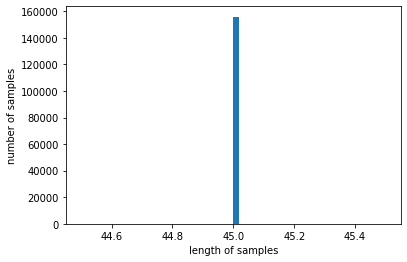

In [134]:
print('문장의 최대 길이 :',max(len(l) for l in X_train)) # 단어의 수
print('문장의 평균 길이 :',sum(map(len, X_train1))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

딥러닝 모듈

In [135]:
from keras import models
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [136]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='mse', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=6000, validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         2248700   
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         117248    
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                                 
 gru_2 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,465,149
Trainable params: 2,465,149
No

In [139]:
loaded_model = load_model('bilstm.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 29s 18ms/step - loss: 0.1206 - acc: 0.8372

 테스트 정확도: 0.8372


In [176]:
from tensorflow.keras.models import load_model
import random
from konlpy.tag import Okt
import os
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

okt = Okt()
stopwords = a
loaded_model = load_model('bilstm.h5')
max_len = 42

global corpus
global avg_emo
global score

corpus = []
avg_emo = 0


heal = ['여수 밤바다', '파주 평화누리공원', '순천 갈대밭', '제주도 영실코스', 
         '진주 진양호', '장흥유원지', '대구 앞산정만대', '춘천 해피초원농장' ,' 속초 해수욕장', 
         '경주 불국사', '포항 호미곶', '남해 두모마을', '대관령 하늘목장', '군산 철길마을', 
         '국립 광릉수목원', '금선사 템플스테이', '보성 제암산자연휴양림','군산 선유도']
 
extreme= ['통영 어드벤처 타워', '제주도  스쿠버다이빙', '단양 패러글라이딩', 
          '강원 내린천 래프팅', '충주 스카이다이빙', '하남 스포츠몬스터', '서울 한강 워터 제트팩', 
          '일산 인공 서핑', '영월 동강래프팅', '여수 스카이플라이', '문경 패러글라이딩', 
          '경남 하동 하동알프스레포츠', '인천 스카이 짚라인', '강화 루지']
 
movie=['루카','콰이어트 플레이스','크루엘라','컨저링 3:악마가 시켰다','여고괴담 여섯번째 이야기','분노의 질주: 더 얼티메이트','캐시트럭',
'클라이밍',
'그 여름, 가장 차가웠던',
'폭력의 그림자',
'청춘 선거',
'그레타 툰베리',
'낫아웃',
'마세티 킬즈',
'프로페서 앤 매드맨',
'화이트 온 화이트',
'아야와 마녀',
'까치발',
'플래시백',
'애플',
'혼자 사는 사람들',
'강호아녀',
'파이프라인',
'분노의 질주']
 
#음악 (네이버 바이브 참고 1위~20위)
 
k_balad=['Timeless-SG워너비',
'추적이는 여름 비가 되어-장범준',
'밤하늘의 별을 (2020)-경서',
'어떻게 이별까지 사랑하겠어, 널 사랑하는 거지-AKMU (악동뮤지션)',
'내 입술 따뜻한 커피처럼-청하 Colde(콜드)',
'서울의 잠 못 이루는 밤 (Feat. 이수현)-10CM',
'잠이 오질 않네요-장범준',
'I Love U-성시경',
'내사람 (Partner For Life)-SG워너비',
'취기를 빌려-산들',
'안녕 (Hello)-조이',
'밤편지-아이유(IU)',
'Anti-Romantic-투모로우바이투게더',
'너의 모든 순간-성시경',
'좋을텐데 (If Only) (Feat. 폴킴)-조이',
'봄 안녕 봄-아이유(IU)',
'Love poem -아이유(IU)',
'아이와 나의 바다-아이유(IU)',
'벌써 일년-반하나& MJ(써니사이드)',
'이렇게 좋아해 본 적이 없어요 -CHEEZE (치즈)'
]
 
k_dance=[
'Butter-방탄소년단',
'Next Level-aespa',
'Dun Dun Dance-오마이걸(OH MY GIRL)',
'치맛바람 (Chi Mat Ba Ram)-브레이브걸스(Brave Girls)',
'Alcohol-Free-TWICE(트와이스)',
"롤린 (Rollin')-브레이브걸스(Brave Girls)",
'라일락-아이유(IU)',
'ASAP-STAYC(스테이씨)',
'Dynamite-방탄소년단',
'상상더하기-MSG워너비',
'Celebrity-아이유(IU)',
'상상더하기-라붐(LABOUM)',
'Ready to love-세븐틴',
'Dolphin-오마이걸(OH MY GIRL)',
'Lovesick Girls-BLACKPINK',
'Pool Party (Feat. 이찬 of DKB)-브레이브걸스(Brave Girls)',
"Heaven's Cloud-세븐틴",
'체념-정상동기(김정수, 정기석, 이동휘, 이상이)',
'어푸 (Ah puh)-아이유(IU)',
]
 
k_hip=[
'마.피.아. In the morning-ITZY(있지)',
'봄날-방탄소년단',
'Life Goes On-방탄소년단',
'맛 (Hot Sauce)-NCT DREAM',
'밸런스 게임-투모로우바이투게더',
'GAM3 BO1-세븐틴',
'비도 오고 그래서 (Feat. 신용재)-헤이즈 (Heize)',
'METEOR-창모(CHANGMO)',
'DNA-방탄소년단',
'IDOL-방탄소년단',
'FAKE LOVE-방탄소년단',
'피 땀 눈물-방탄소년단',
'사이렌-호미들',
'멜로디-ASH ISLAND',
'I NEED U-방탄소년단',
'아무노래-지코 (ZICO)',
'어떻게 지내 (Prod. By VAN.C)-오반(OVAN)',
'Rainy day (Feat. ASH ISLAND, Skinny Brown)-PATEKO(파테코)',
'뚜두뚜두 (DDU-DU DDU-DU)-BLACKPINK']
 
 
trt=[
'이제 나만 믿어요-임영웅',
'별빛 같은 나의 사랑아-임영웅',
'다시 사랑한다면 (김필 Ver.)-임영웅',
'HERO-임영웅',
'미워요-임영웅',
'잊어야 한다는 마음으로-임영웅',
'계단말고 엘리베이터-임영웅',
'소나기-임영웅',
'바보같지만-임영웅',
'따라따라-임영웅',
'당신-임영웅',
'내 마음 별과 같이-임영웅',
'고맙소-김호중',
'만개 (Prod. 신지후)-김호중',
'나보다 더 사랑해요-김호중',
'애인이 되어줄게요 (Prod. 알고보니, 혼수상태)-김호중',
'퇴근길-김호중',
'할무니-김호중',
'우산이 없어요-김호중',
'천년의 사랑-김호중'
]
 
 
f_dance=[
'You-Regard, Troye Sivan, Tate McRae',
'Closer (Feat. Halsey)-The Chainsmokers',
'Faded-Alan Walker',
'One Kiss-Calvin Harris, Dua Lipa',
'Heartbreak Anthem-Galantis, David Guetta, Little Mix',
'Something Just Like This-The Chainsmokers, Coldplay',
'This Is What You Came For (Feat. Rihanna)-Calvin Harris',
'The Middle-Zedd, Grey, Maren Morris',
'Symphony (Feat. Zara Larsson)-Clean Bandit',
'Wake Me Up-Avicii',
'Waste It On Me (Feat. BTS(방탄소년단))-Steve Aoki',
'How To Love (Feat. Sofia Reyes)-Cash Cash',
'Bad Boy (with Wiz Khalifa, bbno$, MAX)-Yung Bae, Wiz Khalifa, bbno$, MAX',
'Titans (Feat. Sia & Labrinth) (Imanbek Remix)-Major Lazer',
'Feels (Feat. Pharrell Williams, Katy Perry, Big Sean)-Calvin Harris',
'Rise (Feat. Jack & Jack)-Jonas Blue',
'Mama (Feat. William Singe)-Jonas Blue',
'Just Got Paid (Feat. French Montana)-Sigala, Ella Eyre, Meghan Trainor',
'Love Line-Shift K3y, Tinashe',
'Lonely Together (Feat. Rita Ora)-Avicii'
]
 
newage=[
'River Flows In You-이루마',
'Letter From The Earth (지구에서 온 편지)-김광민',
'익숙한 그 집 앞-유희열',
'처음부터 지금까지 (Inst.)-박정원',
'냉정과 열정 사이 OST (冷靜と情熱のあいだ)-Ryo Yoshimata',
'''Tomorrow's Promise-Kevin Kern''',
"Mia & Sebastian's Theme-Justin Hurwitz",
'Recuerods de la Alhambra (알함브라 궁전의 추억)-Claude Ciari',
'''Gabriel's Oboe-Ennio Morricone''',
'Rain-Ryuichi Sakamoto',
'Romance-Yuhki Kuramoto',
'Second Romance-Yuhki Kuramoto',
'Crystal Rainbow-데이드림(Daydream)',
'My Road (Live)-Lee Oskar',
'Last Carnival-Acoustic Cafe',
'Return To The Heart-David Lanz',
'Adagio-Secret Garden',
'Loving You-Kenny G'
]

korean = ["삼계탕", "삼겹살", "곱창", "찜닭", "오리고기", "소고기", 
          "국밥", "닭도리탕", "낙곱새", "라면", "비빔밥", "칼국수", 
          "수제비", "갈비", "제육볶음"]

western = ["스테이크", "파스타", "필라프", "감바스", "리조또", "샐러드", 
           "피자", "빠에야", "플래터", "스튜"]

asian = ["짜장면", "뿌팟퐁커리", "팟타이", "나시고랭", "쌀국수", "미고랭",
         "카레", "마라탕", "마라샹궈", "훠궈", "돈까스", "월남쌈", "라멘", 
         "탄탄멘", "규동", "꿔바로우", "똠양꿍", "물냉면"]

spicy = ["떡볶이", "김치찜", "김치찌개", "감자탕", "짬뽕", "닭발", "부대찌개",
         "순두부찌개", "아구찜", "해물찜", "육개장", "낙지볶음", "쭈꾸미", 
         "돼지갈비찜", "소꼬리찜", "비빔냉면"]

dessert = ["와플", "마카롱", "빙수", "크로크모슈", "케이크", "허니바게트볼",
           "머쉬룸수프볼", "에그데니쉬", "케이크", "치아바타", "호두파운드케이크",
           "쿠키", "허니브레드", "오믈렛", "베이글"]

snack = ["닭강정", "양꼬치", "핫윙", "소떡소떡", "가라아게", "콘치즈", "감자튀김", 
         "치킨너겟", "치킨", "낫쵸", "소시지", "버터구이", "계란찜", "핫도그", 
         "해쉬브라운"]

coffee = ["아메리카노", "콜드브루", "바닐라 라떼", "카페 라떼", "카라멜 마키아또",
          "카페 모카", "바닐라 프라페", "카페모카 프라페", "연유 라떼", "화이트 모카",
          "민트 모카", "헤이즐넛 라떼", "에스프레소", "오곡 프라페", "쿠앤크 프라페"]

beverage = ["초코 라떼", "민트초코 라떼", "밀크티", "흑당 버블티", "레몬차", "자몽차",
            "유자차", "모히토", "요거트 스무디", "블루베리 스무디", "딸기 스무디", "애플망고 스무디",
            "레몬 에이드", "자몽 에이드", "생과일 주스"]

motivation = ["자신을 믿어라. 자신의 능력을 신뢰하라. 겸손하지만 합리적인 자신감 없이는 성공할 수도 행복할 수도 없다. - 노먼 빈센트 필",
"조금 더 많이 인내하자. 조금 더 많이 노력하자. 그러면 절망적 실패로 보였던 것이 빛나는 성공으로 변할 수 있다. - 알버트 휴버드",
"당신이 인생의 주인공이기 때문이다. 그 사실을 잊지말라. 지금까지 당신이 만들어온 의식적 그리고 무의식적 선택으로 인해 지금의 당신이 있는것이다. - 바바라 홀",
"먹는 칼로리보다 에너지 소모가 적으면 살이 찌듯이, 걱정만 하고 행동하지 않으면 걱정이 찐다.",
"이미 끝나버린 일을 후회하기 보다는 하고 싶었던 일을 하지 못한 것을 후회하라 - 탈무드",
"기회가 주어지면 최선을 다하는 것이 아니라 최선을 다하고 있으면 기회가 주어지는 것이다 - 신영준",
"낭비한 시간에 대한 후회는 더 큰 시간 낭비이다 - 메이슨 쿨리",
"성공은 매일 부단하게 반복된 작은 노력의 합산이다.",
"현명한 사람은 앉아서 손해 본 것을 한탄만 하지 않고 즐겁게 그 손해를 회복할 방법을 찾는다. - 셰익스피어",
"고통을 주지 않는것은 쾌락도 주지 않는다 - 몽테뉴",
"시간은 간다",
"살아가는 사람들 중 대부분은 자신에게 올 기회를 기다리나 기회라는 것은 기다리는 사람에게는 쉽게 오지 않는 법이다",
"기회를 얻을 수 있게 기다리는 사람이 되기보다는 기회를 얻을 수 있는 실력을 먼저 쌓아야 한다. 자신이 하는 일에 열중하고 노력하다보면 자연스럽게 기회는 찾아온다.",
"변화를 위해서 가장 중요한 것은 행동하는 첫걸음이다.",
"무엇이든 하루아침에 만들어지는 것은 없다. 로마 또한 하루아침에 만들어지지 않았다. 이 말은 무언가를 만들기 위해서는 그것을 만들기 위해 노력하고 집중 해야 한다는 것이다.",
"스스로를 믿고 자신이 가지고 있는 능력을 신뢰해야 한다. 하지만 거만하게 행동하지 말고 겸손해라. 성공을 위해서 자신감이 필요하지만 오만함은 필요하지 않다.",
             "끝난 일은 언급할 필요가 없으며 지난 일은 허물을 물을 필요가 없다. - 공자",
"어렵고 힘든 상황일수록 서두르지 말고 침착해라. 성급하게 하는 행동에는 실수가 포함되기 쉽다.",
"나의 하루를 설명할 수 있는 사람이 곁에 있다는 건 생각보다 기분 좋은 일이야 그러니 너도 생각보다 좋은 사람이지 - 흔글",
"잠 못 자고 있지, 얼른 자, 걱정하는 일 안 생겨 좋은 일은 아니더라도 아무 일 없을 거야 혼자 있는 새벽을 걱정으로 보내지는 마 - 흔글",
"봄바람도 살랑살랑 불고 꽃도 예쁘게 피어있으니 얼마나 놀고 싶겠냐만은, 그래도 그 시간들을 이겨내면 너의 인생에 꽃이 필 테니 조금만 참고 바람을 이겨내기를 - 흔글"]

category = [heal,extreme,movie,k_balad,k_dance,k_hip,trt,f_dance,newage,korean,western,asian,spicy,dessert,snack,coffee,beverage]
f8 = [extreme,movie,k_balad,k_dance,k_hip,trt,f_dance,korean,western,asian,spicy,dessert,snack,coffee,beverage]
f6 = [extreme,movie,k_balad,k_dance,k_hip,trt,f_dance,korean,western,asian,spicy,dessert,snack,coffee,beverage]
f3 = [heal,extreme,movie,k_balad,k_dance,k_hip,trt,f_dance,newage,korean,western,asian,spicy,dessert,snack,coffee,beverage, dessert]
f1 = [heal,movie,k_balad,k_dance,k_hip,trt,f_dance,newage,korean,western,asian,spicy,dessert,snack,coffee,beverage, dessert]
f0 = [heal,movie,k_balad,k_dance,k_hip,f_dance,newage,korean,western,asian,spicy,spicy,dessert,snack,snack,coffee,beverage]

def recomend_sys(new_sentence):
    global score
    global timecheck
    global corpus
    global score
    global avg_emo

    print(new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))
        
    corpus.append(score)
    if len(corpus) >= 5:
        avg_emo = sum(corpus)/len(corpus)
        if(avg_emo > 0.8):
            pick = random.choice(f8)
            if pick == motivation: # | pick == rest:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("당신을 위한 한마디 : {1}\n".format(random.choice(pick)))
                corpus=[]
            else:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("오늘처럼 좋은 날엔 {0} 어떠신가요?\n".format(random.choice(pick)))
                corpus=[]

        elif(avg_emo > 0.6): 
            pick = random.choice(f6)
            if pick == motivation: # | pick == rest:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("당신을 위한 한마디 : {1}\n".format(random.choice(pick)))
                corpus=[]
            else:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("좋은 일있으신가요? 오늘 {0} 어떠세요?\n".format(random.choice(pick)))
                corpus=[]
        elif(avg_emo > 0.4) :
            pick = random.choice(category)
            if pick == motivation: # | pick == rest:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("당신을 위한 한마디 : {1}\n".format(random.choice(pick)))
                corpus=[]
            else:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("오늘같은 날에는 {0} 어때요? 기분이 좋아질거에요!!\n".format(random.choice(pick)))
                corpus=[]
        elif(avg_emo > 0.3) :
            pick = random.choice(f3)
            if pick == motivation: # | pick == rest:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("당신을 위한 한마디 : {1}\n".format(random.choice(pick)))
                corpus=[]
            else:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("꿀꿀한 오늘 {0} 추천해요.\n".format(random.choice(pick)))
                corpus=[]
        elif(avg_emo > 0.18) :
            pick = random.choice(f1)
            if pick == motivation: # | pick == rest:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("당신을 위한 한마디 : {1}\n".format(random.choice(pick)))
                corpus=[]
            else:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("오늘 {0} 어떠세요? 안좋은 기분을 환기시켜줄 거에요.\n".format(random.choice(pick)))
                corpus=[]
        else:
            pick = random.choice(f0)
            if pick == motivation: # | pick == rest:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("당신을 위한 한마디 : {1}\n".format(random.choice(pick)))
                corpus=[]
            else:
                print("기분 점수 : {0:.2f}".format(avg_emo*100))
                print("오늘 안좋은 일이 있으셨나요. 오늘같은 날 {0} 어떠세요?\n".format(random.choice(pick)))
                corpus=[]
    else:
        print('감정 분석까지 {0}개의 문장이 남았어요!'.format(5-len(corpus)))

In [202]:
recomend_sys(input())

석정이는 종원이를 좋아해
82.31% 확률로 긍정 리뷰입니다.

감정 분석까지 4개의 문장이 남았어요!


In [204]:
recomend_sys(input())

아 재밌다 ㅋㅋㅋㅋㅋ 사실 거짓말임
80.03% 확률로 부정 리뷰입니다.

감정 분석까지 2개의 문장이 남았어요!


In [210]:
recomend_sys(input())

담배 마렵다
61.05% 확률로 부정 리뷰입니다.

감정 분석까지 1개의 문장이 남았어요!


In [201]:
recomend_sys(input())

이게 영화냐 신의 기술이지
93.38% 확률로 긍정 리뷰입니다.

기분 점수 : 62.03
좋은 일있으신가요? 오늘 콘치즈 어떠세요?



In [196]:
recomend_sys(input())

이런류의 영화는 이제 안나왔으면 좋겠다
82.03% 확률로 부정 리뷰입니다.

기분 점수 : 50.50
오늘같은 날에는 치킨너겟 어때요? 기분이 좋아질거에요!!

